<a href="https://colab.research.google.com/github/ShreySaklani/DeepLearning/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

Reading Dataset from Google Drive

In [ ]:
df_true = pd.read_csv("/content/drive/MyDrive/FakeNews_DeepLearning/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/FakeNews_DeepLearning/Fake.csv")

Setting up a target variable and combining both the real and fake news datasets

In [ ]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  ...                                           original
0  As U.S. budget fight looms, Republicans flip t...  ...  As U.S. budget fight looms, Republicans flip t...
1  U.S. military to accept transgender recruits o...  ...  U.S. military to accept transgender recruits o...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  Senior U.S. Republican senator: 'Let Mr. Muell...
3  FBI Russia probe helped by Australian diplomat...  ...  FBI Russia probe helped by Australian diplomat...
4  Trump wants Postal Service to charge 'much mor...  ...  Trump wants Postal Service to charge 'much mor...

[5 rows x 6 columns]

Check for the null values in the data

In [ ]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# **Data Cleaning**

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# **EDA**

Find difference of distribution of Subjects between the True and Fake News

In [ ]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

Which Subjects have received the most News Coverage?

In [ ]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

Can the News Headline be enough to predict if the news if fake or not? Lets us see in the following analysis

In [ ]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [ ]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

# Word Cloud using the Real News Headlines

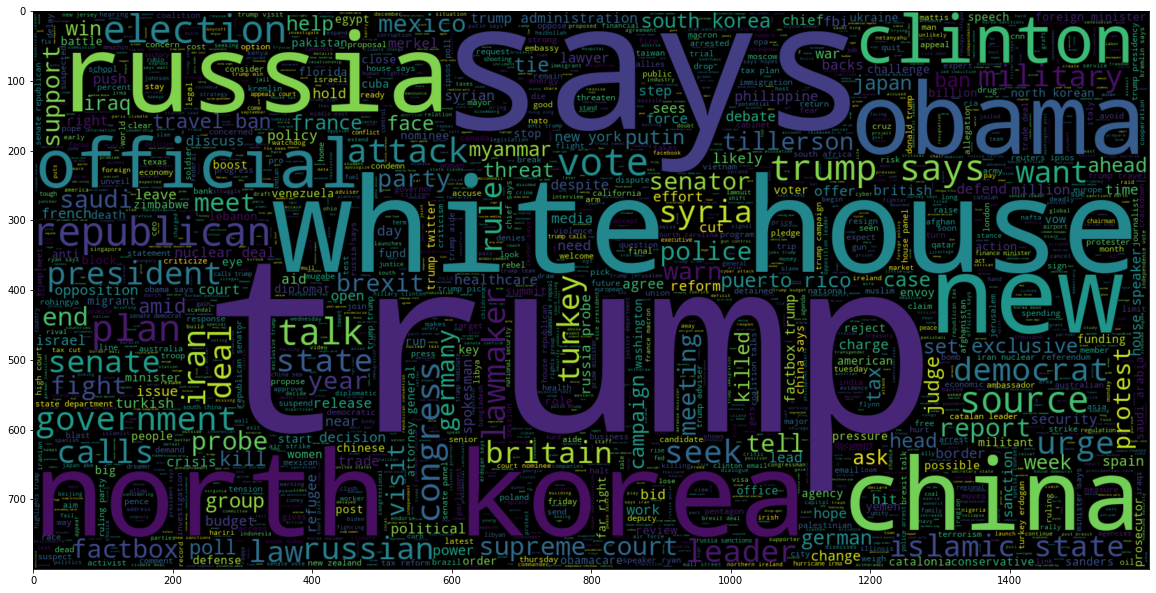

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# Word Cloud using the Fake News Headlines

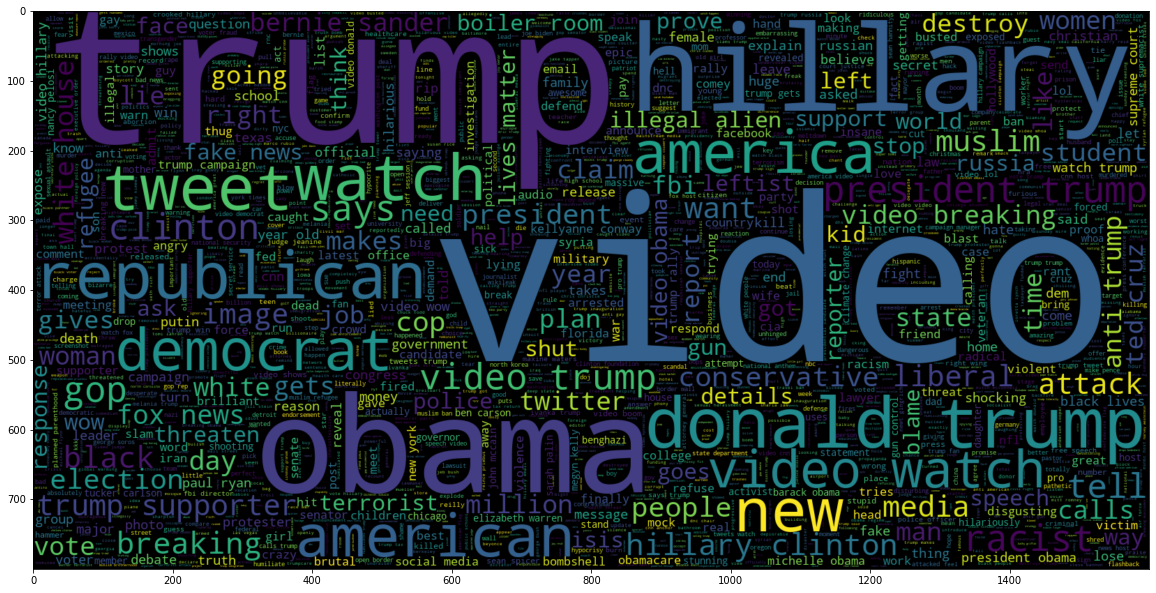

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

The Count of Words Distribution in the Title

In [ ]:
nltk.download('punkt')
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
The maximum number of words in a title is = 34


# Prediction:
How much accurately can we predict if the News is True or Fake just from the Title?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [ ]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.947466974653341


# The Confusion Matrix

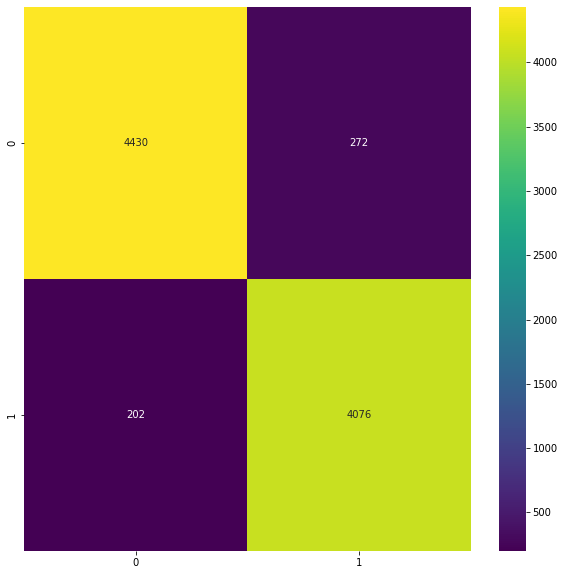

In [ ]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

Lets Check if the Content of the News is enough to predict if the news if fake or not? Lets us see in the following analysis

In [ ]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

**Word Cloud using the Real News Writeups**

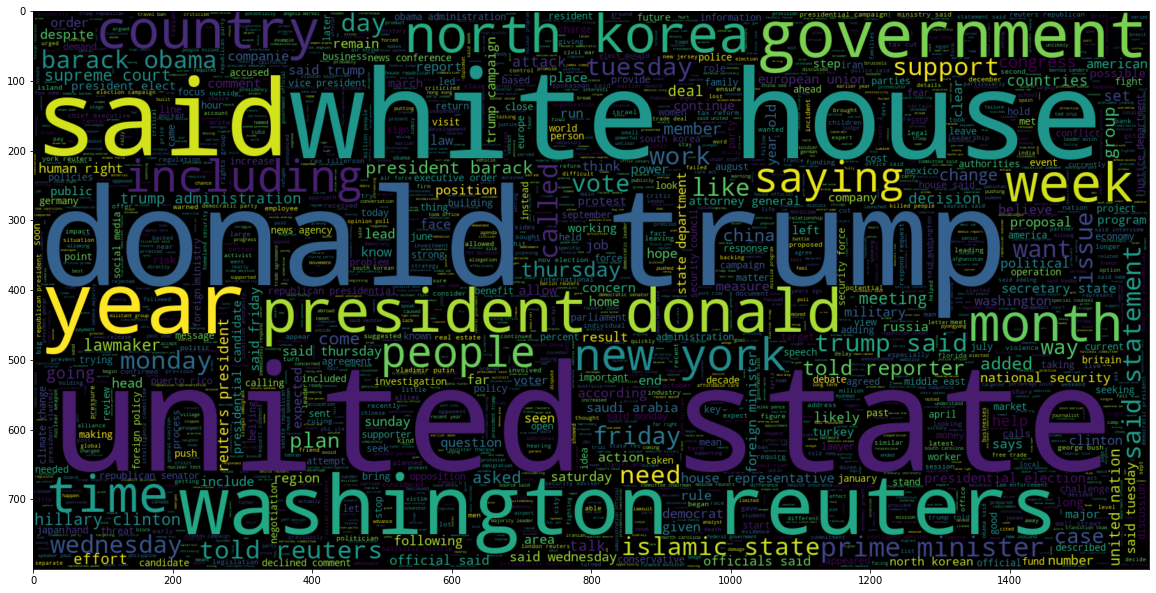

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

**Now Creating a Word Cloud using the Fake News Writeups**

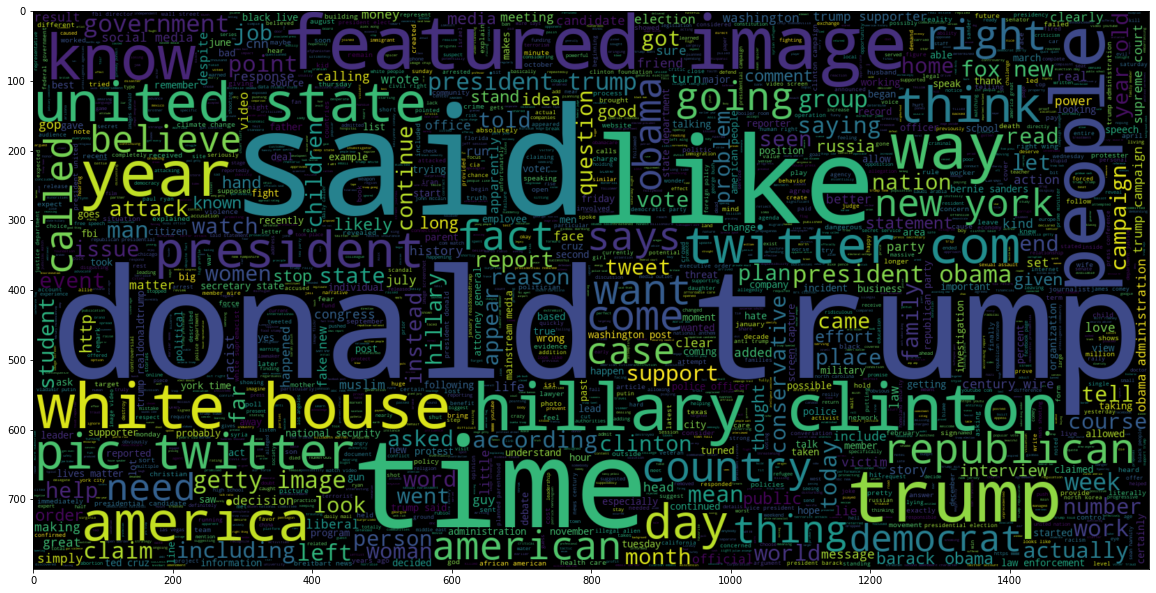

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

Lets try to identify the distribution of word counts in the texts

In [ ]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4574


# Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953661308915527


# The Confusion Matrix

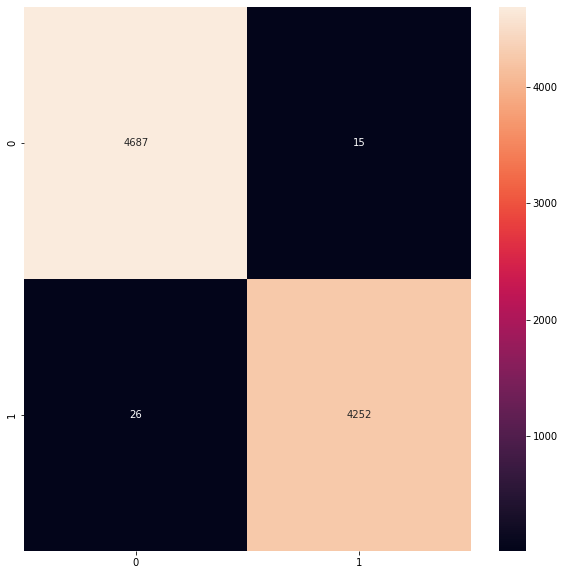

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

Lets find how accurately can we predict if we consider the entire news- Title and Content

In [ ]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

Prediction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9966717508706907


Confusion Matrix

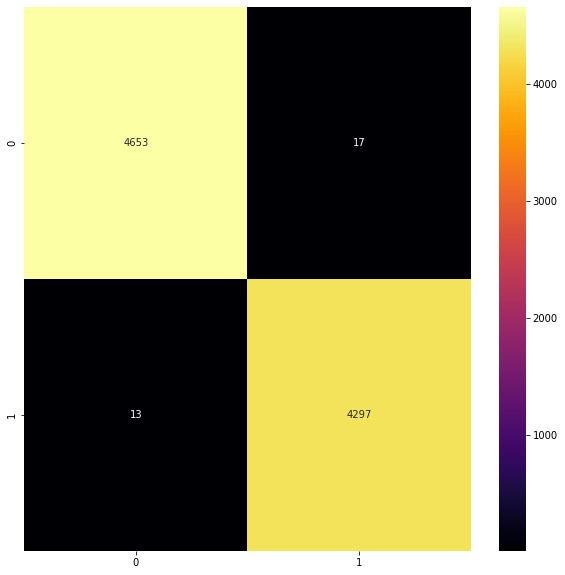

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

# LSTM

In [ ]:
fake_news = pd.read_csv('/content/drive/MyDrive/FakeNews_DeepLearning/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/FakeNews_DeepLearning/True.csv')

print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [ ]:
fake_news['output']=0

true_news['output']=1

In [ ]:
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [ ]:
fake_news['date'].value_counts()

May 10, 2017                                                                                                                                         46
May 5, 2016                                                                                                                                          44
May 6, 2016                                                                                                                                          44
May 26, 2016                                                                                                                                         44
May 11, 2016                                                                                                                                         43
                                                                                                                                                     ..
November 12, 2017                                                                       

In [ ]:
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

In [ ]:
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

In [ ]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

subject  ... output
0           News  ...      0
1           News  ...      0
2           News  ...      0
3           News  ...      0
4           News  ...      0
...          ...  ...    ...
21412  worldnews  ...      1
21413  worldnews  ...      1
21414  worldnews  ...      1
21415  worldnews  ...      1
21416  worldnews  ...      1

[44888 rows x 4 columns]

In [ ]:
clean_news=news_dataset.copy()

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
import string
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

subject       date                                               news  output
0    News 2017-12-31   donald trump sends out embarrassing new year’...       0
1    News 2017-12-31   drunk bragging trump staffer started russian ...       0
2    News 2017-12-30   sheriff david clarke becomes an internet joke...       0
3    News 2017-12-29   trump is so obsessed he even has obama’s name...       0
4    News 2017-12-25   pope francis just called out donald trump dur...       0

In [ ]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

subject       date                                               news  output
0    News 2017-12-31  donald trump sends embarrassing new year’s eve...       0
1    News 2017-12-31  drunk bragging trump staffer started russian c...       0
2    News 2017-12-30  sheriff david clarke becomes internet joke thr...       0
3    News 2017-12-29  trump obsessed even obama’s name coded website...       0
4    News 2017-12-25  pope francis called donald trump christmas spe...       0

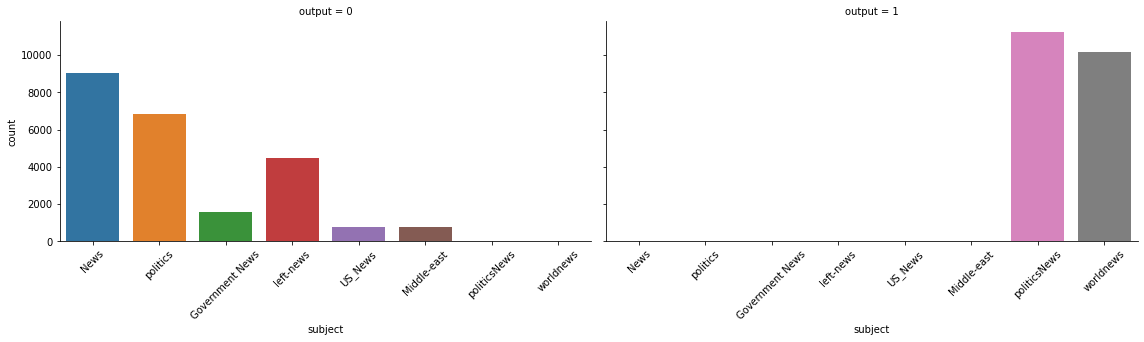

In [ ]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

In [ ]:
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

news
0  donald trump sends embarrassing new year’s eve...
1  drunk bragging trump staffer started russian c...
2  sheriff david clarke becomes internet joke thr...
3  trump obsessed even obama’s name coded website...
4  pope francis called donald trump christmas spe...

In [ ]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

In [ ]:
y=clean_news['output']

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


In [ ]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2245 1563 3545]
 [   0    0    0 ... 9061 5551 3545]
 [   0    0    0 ... 3202 5595 3545]
 ...
 [   0    0    0 ... 7283 7575 3209]
 [   0    0    0 ... 2054 2573 1015]
 [   0    0    0 ... 9366 3928  143]]


In [ ]:
embedded_docs[1]

array([   0,    0,    0, ..., 9061, 5551, 3545], dtype=int32)

In [ ]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(44888, (44888,))

In [ ]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=3,batch_size=64)

Epoch 1/3
470/470 [==============================] - 3490s 7s/step - loss: 0.1622 - accuracy: 0.9395 - val_loss: 0.0608 - val_accuracy: 0.9816
Epoch 2/3
470/470 [==============================] - 3500s 7s/step - loss: 0.0514 - accuracy: 0.9848 - val_loss: 0.0400 - val_accuracy: 0.9889
Epoch 3/3
470/470 [==============================] - 3516s 7s/step - loss: 0.0757 - accuracy: 0.9740 - val_loss: 0.0542 - val_accuracy: 0.9839


In [ ]:
# Predicting from test data
y_pred=model.predict(X_test)

In [ ]:
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))